In [1]:
import sys
sys.path.append('./Documents/github/PAD/src/')
import Analyzer
import Grapher
import Munger
import Plasma_Plotter
import Scraper

In [2]:
num_channels = 32*16*32
chosen_stride = 0

In [3]:
dist = ['c:/Users/cschiff/Downloads/CDFs/mms2_fpi_brst_l2_des-dist_20151016130524_v3.3.0.cdf']
fgm  = ['c:/Users/cschiff/Downloads/CDFs/mms2_fgm_brst_l2_20151016130524_v4.18.0.cdf']
moms = ['c:/Users/cschiff/Downloads/CDFs/mms2_fpi_brst_l2_des-debug_20151016130524_v3.3.0.cdf']

In [4]:
dist_munge = Munger.make_munge_via_translation('mms2','edist',Munger.des_delta,dist,Munger.edist_translation)

segment 1 - start: 2015-10-16 13:05:24.013945 stop 2015-10-16 13:07:43.965933
fresh segment - first stride
Munged 1 series for edist on mms2!


In [5]:
fgm_munge = Munger.make_munge_via_translation('mms2','fgm',Munger.fgm_delta,fgm,Munger.fgm_translation)

segment 1 - start: 2015-10-16 13:05:24.580997 stop 2015-10-16 13:07:43.574761
fresh segment - first stride
Munged 1 series for fgm on mms2!


In [6]:
moms_munge = Munger.make_munge_via_translation('mms2','emoms',Munger.des_delta,moms,Munger.emoms_translation)

segment 1 - start: 2015-10-16 13:05:24.013945 stop 2015-10-16 13:07:43.965933
fresh segment - first stride
Munged 1 series for emoms on mms2!


In [7]:
efgm_munge = Munger.adapt_munge_to_munge(fgm_munge,moms_munge)

fgm flavored


In [8]:
Analyzer.make_record_varying(dist_munge,'thetas')

In [9]:
Analyzer.calculate_B_local_transformation(efgm_munge,moms_munge)

In [10]:
Analyzer.calculate_incoming_particle_directions(dist_munge)

In [11]:
Analyzer.calculate_incoming_particle_velocities(dist_munge,'electrons')

### QQQ is a current shorthand for velocities converted to local magnetic

In [12]:
time_label = 3272
QQQ = np.array([efgm_munge[0]['T_localB'][time_label].dot(dist_munge[0]['vels'][time_label,i,:]) for i in range(num_channels)])

""" def calc_index(data,data_bin):
    delta   = data_bin[1] - data_bin[0]
    num_pts = len(data_bin) 
    
    index = np.around((data-data_bin[0])/delta).astype(int)
    flag  = np.ones(len(data))
    
    subzero_indices          = np.where(index < 0)
    over_9000_indices        = np.where(index > num_pts - 1)
    index[subzero_indices]   = 0
    flag[subzero_indices]    = 0.0
    index[over_9000_indices] = num_pts - 1
    flag[over_9000_indices]  = 0.0
    
    return index, flag"""

In [13]:
compx = 1
compy = 2

In [14]:
min_vel    = -10000
max_vel    = 10000
Dx         = 1000
num_points = (max_vel - min_vel)/Dx + 1

dist_grid     = np.zeros((num_points,num_points))
N_grid        = np.zeros((num_points,num_points))
x_bin         = np.linspace(min_vel,max_vel,num_points)
y_bin         = np.linspace(min_vel,max_vel,num_points)
x_index, x_f  = Analyzer.calculate_index(QQQ[:,compx],x_bin)
y_index, y_f  = Analyzer.calculate_index(QQQ[:,compy],y_bin)

for i in range(num_channels):
    #determine the bin location
    dist_grid[x_index[i],y_index[i]] += x_f[i]*y_f[i]*dist_munge[chosen_stride]['dist'][time_label].reshape(num_channels)[i]
    N_grid[x_index[i],y_index[i]]    += 1
    
W              = dist_grid/N_grid
W[np.isnan(W)] = 0.0
logW = np.ma.masked_invalid(np.log10(W)) 

C:\Users\cschiff\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


In [15]:
def COM(x_bin,y_bin,dist):
    COM = np.array([0,0])
    M   = np.sum(dist)
    for i in range(len(x_bin)):
        for j in range(len(y_bin)):
            temp = dist[i,j]/M*np.array([x_bin[i],y_bin[j]])
            COM = COM + temp
    
    
    return COM            

In [16]:
def excise_center(x_bin,y_bin,dist,external):
    import copy
    temp = copy.deepcopy(dist)
    for i in range(len(x_bin)):
        for j in range(len(y_bin)):
            if np.abs(x_bin[i]) < external and np.abs(y_bin[j]) < external:
                temp[i,j] = 0.0
                
    return temp    

In [17]:
excised_W = excise_center(x_bin,y_bin,W,2000.0)
log_excised_W = np.ma.masked_invalid(np.log10(excised_W))

C:\Users\cschiff\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [18]:
COM_rect = COM(x_bin,y_bin,W)

In [19]:
COM_rect

array([ 1052.30040674,   -22.74420585])

2015-10-16 13:07:02.175346


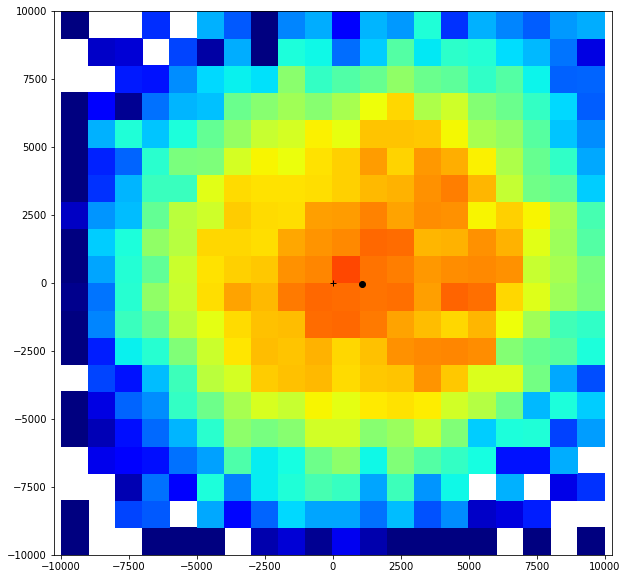

In [20]:
fig_v = plt.figure(figsize=(10,10))
ax_v  = fig_v.add_subplot(1,1,1) 
ax_v.pcolormesh(x_bin,y_bin,logW.T,cmap=cmap.jet,vmin=-30,vmax=-25)
#ax_v.contour(logW.T,15,colors='k')
ax_v.axis('equal')
ax_v.set_xlim([min_vel,max_vel])
ax_v.set_ylim([min_vel,max_vel])
ax_v.plot(COM_rect[0],COM_rect[1],'ko')
ax_v.plot(0,0,'k+')
print dist_munge[chosen_stride]['epochs'][time_label]

In [21]:
min_velr = 2000
max_velr = 11500
Dr       = 500
num_r    = (max_velr - min_velr)/Dr + 1

min_theta = 0
max_theta = 360
Dtheta    = 12
num_theta = (max_theta - min_theta)/Dtheta

dist_grid  = np.zeros((num_r,num_theta))
N_grid     = np.zeros((num_r,num_theta))
radial_bin = np.linspace(min_velr,max_velr,num_r)
ang_bin    = np.linspace(min_theta,max_theta,num_theta)

vels_r     = np.sqrt(QQQ[:,compx]**2 + QQQ[:,compy]**2)
vels_theta = np.arctan2(QQQ[:,compy],QQQ[:,compx])
vels_theta[vels_theta<0.0] = vels_theta[vels_theta<0.0] + 2*np.pi
vels_theta = vels_theta*180/np.pi

Ir, Fr = Analyzer.calculate_index(vels_r,radial_bin)
#It, Ft = calc_index(vels_theta,angs*180/np.pi)
It, Ft = Analyzer.calculate_index(vels_theta,ang_bin)

In [22]:
for i in range(num_channels):
    #determine the bin location
    dist_grid[Ir[i],It[i]] += Fr[i]*Ft[i]*dist_munge[chosen_stride]['dist'][time_label].reshape(num_channels)[i]
    N_grid[Ir[i],It[i]]    += 1
W = np.ma.masked_invalid(np.log10(dist_grid/N_grid))

C:\Users\cschiff\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


2015-10-16 13:07:02.175346


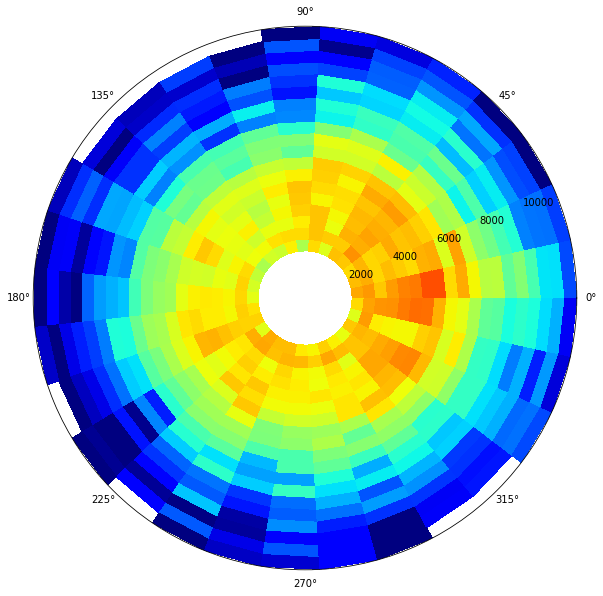

In [23]:
fig_v = plt.figure(figsize=(10,10))
ax_v  = fig_v.add_subplot(1,1,1,projection='polar') 
current_shading = 'flat'
#ax_v.pcolormesh(angs,radial_bin,W,cmap=cmap.jet,vmin=-30,vmax=-25,shading='gouraud')
#ax_v.contour(ang_bin*np.pi/180.0,radial_bin,W,7,colors='k')
ax_v.pcolormesh(ang_bin*np.pi/180,radial_bin,W,cmap=cmap.jet,vmin=-29.5,vmax=-25,shading=current_shading)

print dist_munge[chosen_stride]['epochs'][time_label]